# MARMOUSI ACOUSTIC MODEL 

this notbook show how use an external model stored in regular grid. We consider the acoustic case and the Marmousi model extended to 3D.  

## 0 Prepare model data

create 3D marmousi model from 2D marmousi slice in file : marmousi_elastic_2D.h5  
   extension in direction y with 501 points with a step of 4 m

   ```python ./create_3D_model.py  --f marmousi_elastic_2D.h5 --ny  501 --oy -1000 --dy 4```

   since the model is invariant in y direction we can do
   
   ```python ./create_3D_model.py  --f marmousi_elastic_2D.h5 --ny  51 --oy -1000 --dy 40```

In [2]:
!python ./create_3D_model.py  --f marmousi_elastic_2D.h5 --ny  501 --oy -1000 --dy 4

Keys: <KeysViewHDF5 ['RHO', 'VP', 'VS']>
Attribues: <KeysViewHDF5 ['description', 'dx', 'dz', 'nx', 'nz', 'ox', 'oz']>
2D marmousi elastic with constant vp/vs and continuously extended on boundary
(2501, 951)
(951, 501, 2501)


## 1 Setup on local computer 

In [1]:
from PySpecfem.SpecfemProject import *
spe = SpecfemProject()

In [2]:
domain = [-300., 9300., -850., 850., -3000., 0.]

In [3]:
element_size = [100., 100., 100.]

In [4]:
spe.setup_domain(coords_system = "cartesian",
                 extent = domain,
                 size_elem = element_size,
                 use_sponge = 1,                             # use sponge absorbing layers
                 absorbing_sponge = [300.,300.,300.,0.01]    # absorbing layer (~3 elements)
                )

The setup for the model is particular, the folowing flag is to prepare specfem to use external acoustic model stored in regular grid. The model is already in the training cluster, you will copy it on your running directory before launching specfem.

In [5]:
spe.setup_model(model_type = "fd_model_ac") # use external model stored in regular 3D grid

In [6]:
spe.setup_station(station_type = "station_grid",
                  station_origin = [0., 0., -150.],  # pressure is 0 at free surface then need to bury the receivers
                  station_step = [25., 0., 0.],
                  station_number = [361, 1, 1],
                  component = 'PR') # we record pressure in acoutic case 

using default station setup.


In [7]:
spe.setup_source(source_type= "shot_grid",               # shot sources  
                 source_origin = [300., 0., -100.],     
                 source_step = [ 0., 0., 0.],
                 source_number = [1, 1, 1],
                 source_ampl = 1e20,                     # amplitude of the source
                 ricker_f0 = 5.,                        # dominant frequency of the source
                 t_shift = -0.1)

### Check the configured model

The cell below outputs setup_vis.vtmb which may be open by Paraview etc.


In [8]:
from PySpecfem.vis_project import SpecToVista

# initialize visualization object
# ndiv_* is the number of grid points used for visualization
vspe = SpecToVista(spe, ndiv_x=100, ndiv_y=100, ndiv_z=50)

# change source size
vspe.rad_rec = 30
vspe.rad_src = 100

# plot
# write visualization file
# with write_vtk=False, pyspecfem will try to open a interactive plot on jupyter
# with docker image, user need to configure for use X11 DISPLAY environment
vspe.plot_3d(fmodel="./fd_grid.h5", write_vtk=True)

In [15]:
spe.setup_path(specfem_directory="/shared/cheese/specfem3d/specfem_fwi")

In [20]:
spe.setup_specfem_config(number_of_mpi_domain = 8,
                         time_length = 6.,
                         time_step = 0.0005,     # sampling for simulation constrained by CFL
                         time_step_data = 0.01,  # sesimogram sampling
                         hdf5_enabled = 0,
                         use_gpu = 0)

In [21]:
spe.setup_script(script_type = "pbs")
#spe.setup_script(script_type = "default")

In [22]:
spe.write_setup_file()
!ls

create_3D_model.py  Gather.bin.hdr	     run		vs.bin
fd_grid.h5	    Marmousi_acoustic.ipynb  setup_file.in
fd_grid.txt	    marmousi_elastic_2D.h5   STATIONS_FILTERED
Gather.bin	    rho.bin		     vp.bin


## 2. Computation in remote training cluster

### Upload configuration file in remote training cluster
Upload setup_file.in in the cluster in directory where specfem will be launch (replace "login@cluster" and  "your_directory" with proper values

In [23]:
#!scp setup_file.in your_login@training.hlrs.de:your_directory/.
!scp setup_file.in sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/marmousi/.


setup_file.in                                   0%    0     0.0KB/s   --:-- ETA
setup_file.in                                 100% 1530     1.5KB/s   00:00    


On the remote cluster, copy the files containing Marmousi model in the running directory

grid description : 

density model

P-wave velocity model

### configure the run by using (in the remote cluster) 
> module load python/3.9

>  pyspecfem_setup setup_file.in

### Launch the 3 steps of specfem computing by qsub or interactively

    the disk space required to run this example is about 6Gb.

In [ ]:
qsub -q smp run_generate_databases_2.pbs
qstat

In [ ]:
qsub -q smp run_FWI_forward.pbs 
qstat

The runtine in 8 cores is about 25 mins in the training cluster.

#### it is possible to download the model for visualization with paraview, but it take about 1Gb of files, it is not recommened to dowload it during the training session.

In [33]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/run_marmousi/model_iso_000000.xdmf .
!mkdir DATABASES_MPI
!mkdir -p OUTPUT_FILES/DATABASES_MPI/

mkdir: cannot create directory ‘DATABASES_MPI’: File exists


In [34]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/run_marmousi/DATABASES_MPI/proc*_grid_gll.bin DATABASES_MPI/.

In [35]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/run_marmousi/DATABASES_MPI/proc*_points_gll.bin DATABASES_MPI/.

In [36]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/run_marmousi/OUTPUT_FILES/DATABASES_MPI/proc*_model_*output.bin OUTPUT_FILES/DATABASES_MPI/.

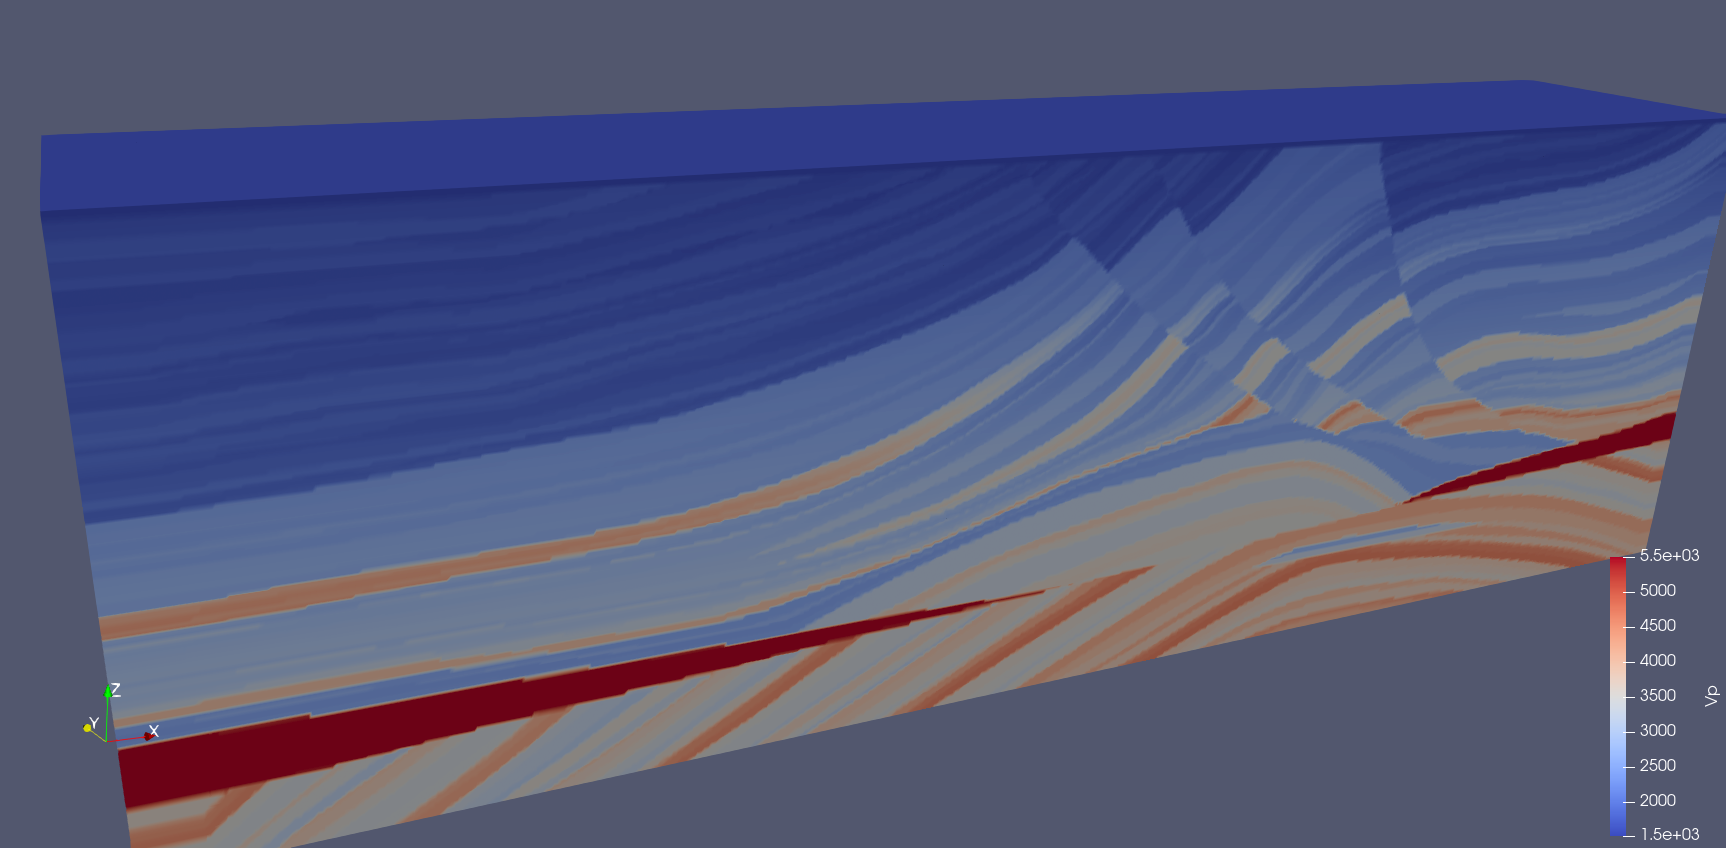

#### The seismograms can be downloaded during the training session

In [24]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/marmousi/DATA_DIR/EV_1/Gather.bin .

Gather.bin                                    100%  846KB 282.0KB/s   00:03    


In [25]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/marmousi/DATA_DIR/EV_1/Gather.bin.hdr .

Gather.bin.hdr                                100%  145     0.1KB/s   00:00    


In [26]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/marmousi/DATA_DIR/EV_1/STATIONS_FILTERED . 

STATIONS_FILTERED                             100%   33KB  33.1KB/s   00:00    


### Display sismograms

In [27]:
from PySpecfem.helper.sismograms import SismoGather
synth0 = SismoGather(verb=False)
synth0.read_inputs("./","Gather.bin","Gather.bin.hdr")

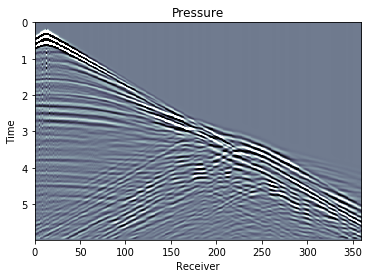

In [28]:
%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt 
fig = plt.figure()
ax = fig.gca()
synth0.display_gather(fig, ax, icomp=0, cliping=0.01, aspect = 40.)

In [29]:
synth0.display_station()

    Network  Station      latitude     longitude      elevation
0        XX  STA0001  0.000000E+00  0.000000E+00  -0.150000E+03
1        XX  STA0002  0.000000E+00  0.250000E+02  -0.150000E+03
2        XX  STA0003  0.000000E+00  0.500000E+02  -0.150000E+03
3        XX  STA0004  0.000000E+00  0.750000E+02  -0.150000E+03
4        XX  STA0005  0.000000E+00  0.100000E+03  -0.150000E+03
5        XX  STA0006  0.000000E+00  0.125000E+03  -0.150000E+03
6        XX  STA0007  0.000000E+00  0.150000E+03  -0.150000E+03
7        XX  STA0008  0.000000E+00  0.175000E+03  -0.150000E+03
8        XX  STA0009  0.000000E+00  0.200000E+03  -0.150000E+03
9        XX  STA0010  0.000000E+00  0.225000E+03  -0.150000E+03
10       XX  STA0011  0.000000E+00  0.250000E+03  -0.150000E+03
11       XX  STA0012  0.000000E+00  0.275000E+03  -0.150000E+03
12       XX  STA0013  0.000000E+00  0.300000E+03  -0.150000E+03
13       XX  STA0014  0.000000E+00  0.325000E+03  -0.150000E+03
14       XX  STA0015  0.000000E+00  0.35

display pressure  300 (600,)


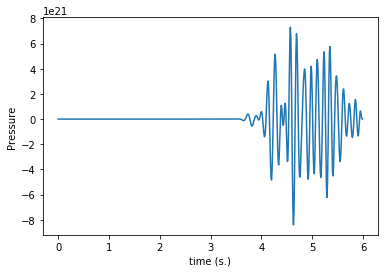

In [32]:
%matplotlib inline
%matplotlib inline
synth0.display_sismogram(irec=300)